In [3]:
import random
import keras
import keras_metrics
import subprocess
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Embedding, Dropout, LSTM, Activation, Conv1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = Tokenizer()

In [4]:
def get_data(bot_file, gen_file):
    x_data = []
    with open(bot_file, 'r', errors='ignore') as file:
        for line in file:
            x_data.append(line)

    size = len(x_data)

    with open(gen_file, 'r', errors='ignore') as file:
        for line in file:
            x_data.append(line)

    y_data = [1] * size + [0] * size

    train_set = list(zip(x_data, y_data))
    random.shuffle(train_set)
    x, y = zip(*train_set)
    return np.array(x), np.array(y)

In [12]:
x, y = get_data('trv-bot.txt', 'trv-gen.txt')

In [13]:
vec = TfidfVectorizer(max_features=100,
                      tokenizer=word_tokenize,
                      strip_accents='unicode',
                      lowercase =True,
                      analyzer='word',
                      token_pattern=r'\w+',
                      use_idf=True,
                      smooth_idf=True,
                      sublinear_tf=False, 
                      stop_words = 'english'
                     )
tfidf_mat = vec.fit_transform(x).toarray()
print(type(tfidf_mat),tfidf_mat.shape)

<class 'numpy.ndarray'> (640000, 100)


In [14]:
model = Sequential()
model.add(Dense(512,input_shape=(100,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy',keras_metrics.precision(), keras_metrics.recall()]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               51712     
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
__________

In [15]:
history = model.fit(tfidf_mat,y,batch_size=64,epochs=10,verbose=1,validation_split=0.25)

Train on 480000 samples, validate on 160000 samples
Epoch 1/10
480000/480000 [==============================] - 30s 62us/step - loss: 0.1881 - acc: 0.9251 - precision: 0.9360 - recall: 0.9125 - val_loss: 0.1622 - val_acc: 0.9362 - val_precision: 0.9550 - val_recall: 0.9156
Epoch 2/10
480000/480000 [==============================] - 29s 61us/step - loss: 0.1599 - acc: 0.9377 - precision: 0.9485 - recall: 0.9256 - val_loss: 0.1539 - val_acc: 0.9379 - val_precision: 0.9516 - val_recall: 0.9227
Epoch 3/10
480000/480000 [==============================] - 30s 62us/step - loss: 0.1523 - acc: 0.9407 - precision: 0.9518 - recall: 0.9285 - val_loss: 0.1493 - val_acc: 0.9425 - val_precision: 0.9525 - val_recall: 0.9314
Epoch 4/10
480000/480000 [==============================] - 30s 62us/step - loss: 0.1475 - acc: 0.9427 - precision: 0.9533 - recall: 0.9309 - val_loss: 0.1473 - val_acc: 0.9428 - val_precision: 0.9554 - val_recall: 0.9291
Epoch 5/10
480000/480000 [==============================] - 

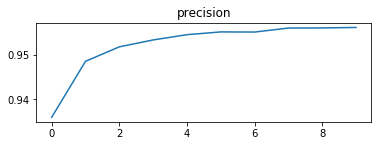

In [16]:
plt.subplot(211)
plt.title('precision')
plt.plot(history.history['precision'], label='train')

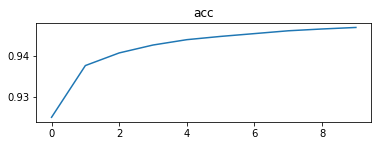

In [17]:
plt.subplot(211)
plt.title('acc')
plt.plot(history.history['acc'], label='train')

In [18]:
x_test, y_test = get_data('test-bot.txt', 'test-gen.txt')

In [19]:
test_tfidf_mat = vec.transform(x_test).toarray()
print(type(test_tfidf_mat),test_tfidf_mat.shape)

<class 'numpy.ndarray'> (160000, 100)


In [58]:
score, acc, p, r = model.evaluate(test_tfidf_mat, y_test)
print('score:', score)
print('accuracy:', acc)
print('precision:', p)
print('recall:', r)

60000/60000 [==============================] - 1s 21us/step
score: 0.13939705604414146
accuracy: 0.9483333333333334
precision: 0.957451874018919
recall: 0.9383666666635387


In [59]:
model.save_weights("tf-idf-spec-model.h5")
print("Saved model to disk")

Saved model to disk
